In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from tqdm import tqdm
import multiprocessing as mp
import os
import pickle
import random
# 把读取所有数据的函数放在单独的python文件中，是为了解决多线程问题在jupyter notebook无法运行的问题
import read_all_data


In [3]:
class Load_Save_Data():
    def __init__(self,file_name=None):
        self.filename = file_name

    def load_data(self,Path=None):
        if Path is None:
            assert self.filename is not None,"Invalid Path...."
        else:
            self.filename = Path
        with open(self.filename,"rb") as f:
            data = pickle.load(f)
        return data

    def save_data(self,data,path):
        if path is None:
            assert self.filename is not None,"Invalid path...."
        else:
            self.filename = path
        with open(self.filename,"wb") as f:
            pickle.dump(data,f)

In [4]:
# 定义读取数据的函数
def read_data(Path,Kind=""):
    """
    :param Path:待读取数据的存放路径
    :param Kind:'train' of 'test'
    """

    # 替换成数据存放的路径
    filenames = os.listdir(Path)
    print("\n@Read Data From"+Path+".........................")
    with mp.Pool(processes=mp.cpu_count()) as pool:
        data_total = list(tqdm(pool.map(read_all_data.read_train_file if Kind == "train" else 
                                        read_all_data.read_test_file,filenames),total=len(filenames)))
    print("\n@End Read total Data............................")
    load_save = Load_Save_Data()
    if Kind == "train":
        load_save.save_data(data_total,"./data_tmp/total_data.pkl")
    return data_total

In [5]:
# 训练数据读取
df_path = '../team-learning-data-mining-master/wisdomOcean/data/'
# 存放数据的绝对路径
train_path = f"{df_path}/hy_round1_train_20200102/"
data_train = read_data(train_path,Kind="train")
data_train = pd.concat(data_train)

# 测试数据读取

# 存放数据的绝对路径
test_path = f"{df_path}/hy_round1_testA_20200102/"
data_test = read_data(test_path,Kind="test")
data_test = pd.concat(data_test)



@Read Data From../team-learning-data-mining-master/wisdomOcean/data//hy_round1_train_20200102/.........................


100%|██████████| 7000/7000 [00:00<00:00, 2032546.07it/s]



@End Read total Data............................

@Read Data From../team-learning-data-mining-master/wisdomOcean/data//hy_round1_testA_20200102/.........................


100%|██████████| 2000/2000 [00:00<00:00, 1590860.61it/s]



@End Read total Data............................


In [6]:
# 把训练集的所有数据,根据类别存放到不同的数据文件中
def get_diff_data():
    Path = "./data_tmp/total_data.pkl"
    with open(Path,"rb") as f:
        total_data = pickle.load(f)

    load_save = Load_Save_Data()

    kind_data = ["刺网","围网","拖网"]
    file_names = ["ciwang_data.pkl","weiwang_data.pkl","tuowang_data.pkl"]
    for i,datax in enumerate(kind_data):
        data_type =  [data for data in total_data if data["type"].unique()[0] == datax]
        load_save.save_data(data_type,"./data_tmp/" + file_names[i])
get_diff_data()

In [7]:
# 从存放某个轨迹类别的数据文件中，随机读取某个渔船的数据
def get_random_one_traj(type=None):
    """
    :param type:"ciwang","weiwang" or "tuowang"
    """
    
    np.random.seed(10)
    path = "./data_tmp/"
    with open(path + type + ".pkl","rb") as f1:
        data = pickle.load(f1)
    length = len(data)
    index = np.random.choice(length)
    return data[index]

In [8]:
# 分别从三个类别的数据文件中，随机读取某三个渔船的数据
def get_random_three_traj(type=None):
    """
    :param type:"ciwang","weiwang" or "tuowang"
    """
    
    random.seed(10)
    path = "./data_tmp/"
    with open(path + type + ".pkl", "rb") as f:
        data = pickle.load(f)
    data_arrange = np.arange(len(data)).tolist()
    index = random.sample(data_arrange,3)
    return data[index[0]],data[index[1]],data[index[2]]

In [9]:
# 每个类别中随机三个渔船的轨迹进行可视化
def visualize_three_traj():
    fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(20,15))
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    # 对于每一个类别，随机选出刺网的三条轨迹进行可视化
    lables = ["ciwang","weiwang","tuowang"]
    for i,file_type in tqdm(enumerate(["ciwang_data","weiwang_data","tuowang_data"])):
        data1, data2, data3 = get_random_three_traj(type=file_type)
        for j, datax in enumerate([data1, data2, data3]):
            x_data = datax["x"].loc[-1:].values
            y_data = datax["y"].loc[-1:].values
            axes[i][j - 1].scatter(x_data[0], y_data[0], label="start", c="red", s=10, marker="8")
            axes[i][j - 1].plot(x_data, y_data, label=lables[i])
            axes[i][j - 1].scatter(x_data[len(x_data) - 1], y_data[len(y_data) - 1], label="end", c="green", s=10,
                                   marker="v")
            axes[i][j - 1].grid(alpha=2)
            axes[i][j - 1].legend(loc="best")

    plt.show()

3it [00:08,  2.68s/it]


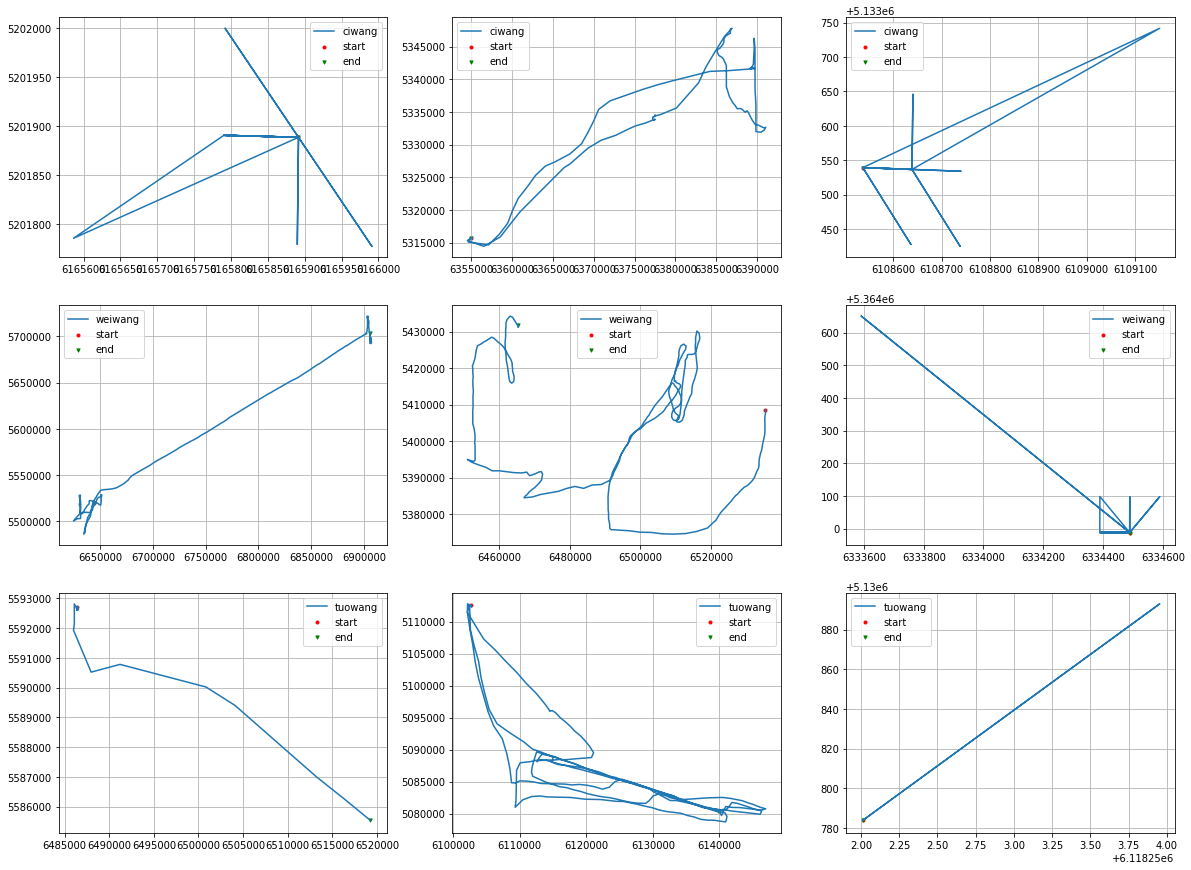

In [10]:
visualize_three_traj()

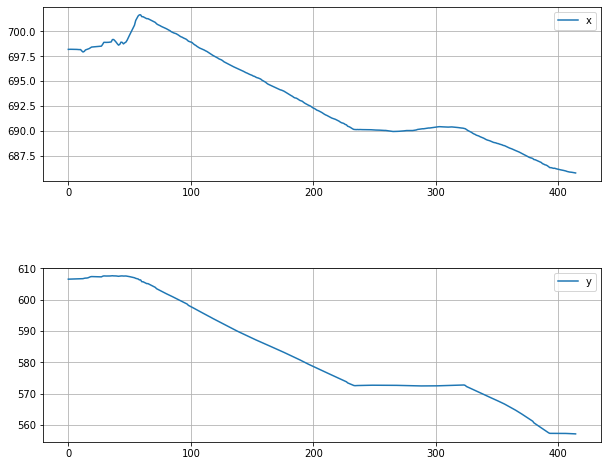

In [11]:
# 随机选取某条数据，观察x坐标序列和y坐标序列的变化情况
def visualize_one_traj_x_y():
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(10,8))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)

    data1 = get_random_one_traj(type="weiwang_data")
    x = data1["x"].loc[-1:]
    x = x / 10000
    
    y = data1["y"].loc[-1:]
    y = y / 10000

    arr1 = np.arange(len(x))
    arr2 = np.arange(len(y))

    axes[0].plot(arr1,x,label="x")
    axes[1].plot(arr2,y,label="y")
    axes[0].grid(alpha=3)
    axes[0].legend(loc="best")
    axes[1].grid(alpha=3)
    axes[1].legend(loc="best")
    plt.show()
visualize_one_traj_x_y()

3it [00:07,  2.43s/it]


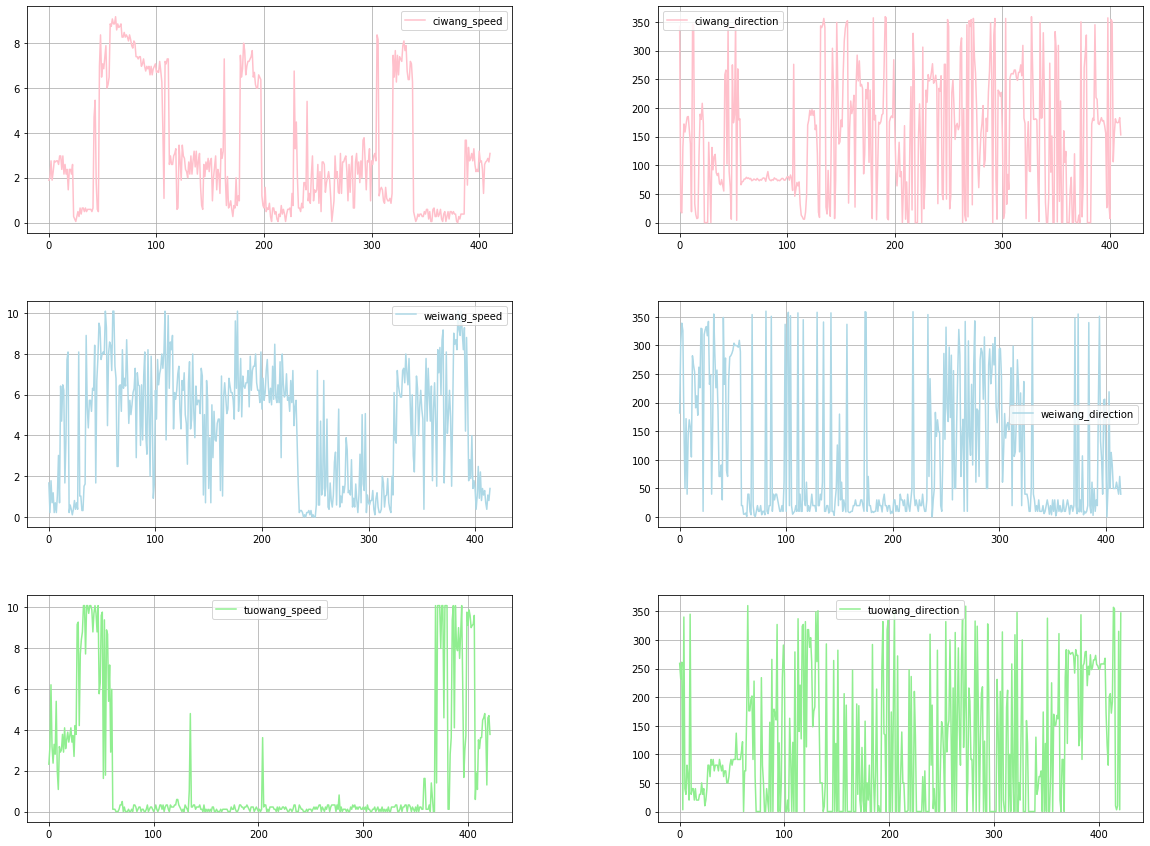

In [13]:
# 每类轨迹，随机选取某个渔船，可视化速度序列和方向序列
def visualize_three_traj_speed_direction():
    fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15))
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    # 随机选出刺网的三条轨迹进行可视化
    file_types = ["ciwang_data","weiwang_data","tuowang_data"]
    speed_types = ["ciwang_speed","weiwang_speed","tuowang_speed"]
    doirections = ["ciwang_direction","weiwang_direction","tuowang_direction"]
    colors = ['pink', 'lightblue', 'lightgreen']
    for i,file_name in tqdm(enumerate(file_types)):
        datax = get_random_one_traj(type=file_name)
        x_data = datax["速度"].loc[-1:].values
        y_data = datax["方向"].loc[-1:].values
        axes[i][0].plot(range(len(x_data)), x_data, label=speed_types[i], color=colors[i])
        axes[i][0].grid(alpha=2)
        axes[i][0].legend(loc="best")
        axes[i][1].plot(range(len(y_data)), y_data, label=doirections[i], color=colors[i])
        axes[i][1].grid(alpha=2)
        axes[i][1].legend(loc="best")

    plt.show()
visualize_three_traj_speed_direction()

In [15]:
# 对某一特征进行数据统计
def get_data_cummulation(type=None,path=None,kind=None,columns=None):
    """
    :param type:"ciwang","weiwang" or "tuowang"
    :param path:存放数据路径
    :param kind: '速度' or  '方向'
    :param columns:与kind对应，'speed' or 'direction'
    """
    
    data_dict = dict()
    with open(path + type+".pkl","rb") as file:
        data_list = pickle.load(file)
    for datax in tqdm(data_list):
        data = datax[kind].values
        for speed in data:
            data_dict.setdefault(speed,0)
            data_dict[speed] += 1
    data_dict = dict(sorted(data_dict.items(),key=lambda x:x[0],reverse=False))
    data_df = pd.DataFrame.from_dict(data_dict,columns=[columns],orient="index")
    return data_df

In [14]:
# 分别得到速度和方向的分布数据
def get_speed_and_direction_distribution_data(type=None):
    """
    :param type:"ciwang","weiwang" or "tuowang"
    """
    
    path = "./data_tmp/"
    data_speed_df = get_data_cummulation(type=type, path=path,kind="速度",columns="speed")
    data_direction_df = get_data_cummulation(type=type,path=path,kind="方向",columns="direction")
    return data_speed_df,data_direction_df

100%|██████████| 4361/4361 [00:01<00:00, 3700.28it/s]


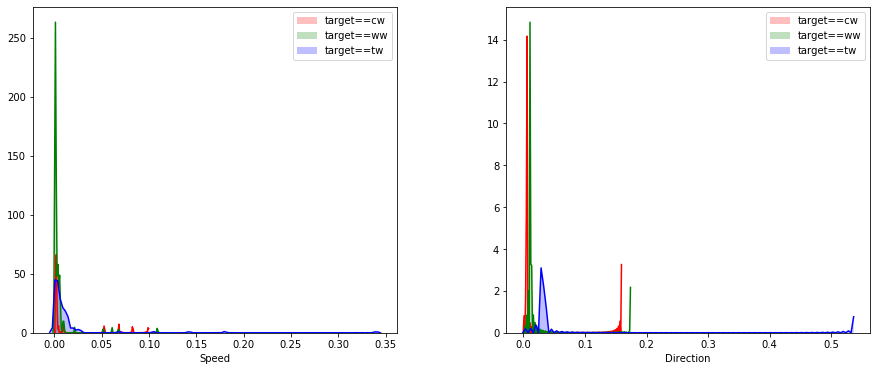

In [16]:
# 可视化速度和方向的数据分布
df_speeds = []
df_directions = []


def plot_speed_direction1_distribution():
    plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    file_types = ["ciwang_data", "weiwang_data", "tuowang_data"]
    lables = ["target==cw", "target==ww", "target==tw"]
    colors = ["red", "green", "blue"]

    for i, filenames in enumerate(file_types):
        df11, df21 = get_speed_and_direction_distribution_data(file_types[i])
        plt.subplot(1,2,1)
        ax1 = sns.kdeplot(df11["speed"].values / 1000000, color=colors[i],shade=True)
        plt.subplot(1,2,2)
        ax3 = sns.kdeplot(df21["direction"].values / 1000000, color=colors[i],shade=True)
        df_speeds.append(df11)
        df_directions.append(df21)
    ax1.legend(lables)
    ax1.set_xlabel("Speed")
    ax3.set_xlabel("Direction")
    ax3.legend(lables)
    plt.show()
plot_speed_direction1_distribution()